In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from rdkit import Chem

from hotbit import Hotbit
import numpy as np
import os
import cclib

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import subprocess
import shlex

from autotst.job import Job as AutoTST_Job
from autotst.species import Conformer, Species
from autotst.calculators.gaussian import Gaussian as AutoTST_Gaussian
from autotst.reaction import Reaction

from rmgpy.molecule import Molecule as RMG_Molecule


Using Theano backend.
/home/underkoffler.c/Code/RMG-Py/rmgpy/tools/plot.py:34: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/underkoffler.c/anaconda2/envs/rmg_env/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/underkoffler.c/anaconda2/envs/rmg_env/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/underkoffler.c/anaconda2/envs/rmg_env/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/underkoffler.c/anaconda2/envs/rmg_env/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
 

In [2]:

def geos_of_interest(parser=None, file_name=None):
    if parser is None:
        assert file_name is not None, "Need either parser or file_name"
        parser = cclib.io.ccread(file_name)

    min_energy = None
    min_coords = None

    atomnos = parser.atomnos

    opt_indices = [idx for idx, status in enumerate(parser.optstatus) if status==2]
    opt_SCFenergies = [parser.scfenergies[idx] for idx in opt_indices]

    init_atomcoords = parser.atomcoords[0]
    init_energy = parser.scfenergies[0]

    first_atomcoords = parser.atomcoords[opt_indices[0]]
    first_energy = parser.scfenergies[opt_indices[0]]

    last_atomcoords = parser.atomcoords[opt_indices[-1]]
    last_energy = parser.scfenergies[opt_indices[-1]]

    lowest_atomcoords = None
    lowest_energy = None
    for opt_idx in opt_indices:
        energy = parser.scfenergies[opt_idx]
        if (energy < lowest_energy) or (lowest_energy is None):
            lowest_energy = energy
            lowest_atomcoords = parser.atomcoords[opt_idx]
    
    geometries = {}
    geometries['scan_init'] = [init_atomcoords, init_energy]
    geometries['sacn_first'] = [first_atomcoords, first_energy]
    geometries['scan_lowest'] = [lowest_atomcoords, lowest_energy]
    geometries['scan_last'] = [last_atomcoords, last_energy]
    
    return geometries

In [3]:
#path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/[CH2]COC/From_Workflow'
#os.chdir(path)
#output_log = 'ZMAYDFGNKOVZRH-UHFFFAOYSA-N_36by10.0_tor01_a2.log'

In [4]:
"""SCF_energy_dict = {}

parser = cclib.io.ccread(output_log)

final_indices = [(i, status) for i, status in enumerate(parser.optstatus) if status>1]
SCFEnergies = [(parser.scfenergies[index], status,  for index in opt_indices]

#SCF_energies = ( (status,parser.scfenergies[i]) for i, status in enumerate(parser.optstatus) if status > 1)
#SCF_energies = {status: parser.scfenergies[i] for i, status in enumerate(parser.optstatus)}

assert len(final_indices) == steps+1, "Number of final geos does not match step size"
angle = 0
step = 0
for i, status in enumerate(parser.optstatus):
    energy = parser.scfenergies[i]
    status = parser.optstatus[i]
    angle += i * step_size 
    if status == 2:
        # Optimized State
        SCF_energy_dict[angle] = energy
        

SCF_energy_dict"""
x=1

In [8]:
def get_SCF_dict(scan_log, steps, step_size):
    parser = cclib.io.ccread(scan_log)

    opt_indices = [i for i, status in enumerate(parser.optstatus) if status==2]
    opt_SCFEnergies = [parser.scfenergies[index] for index in opt_indices]
    

def get_opt_energies(scan_log):
    """
    Sets data attributes using cclib and Arkane

    scan_log :: name of scan log
    path     :: path to scan log
    """
    parser = cclib.io.ccread(scan_log)
    opt_indices = [i for i, status in enumerate(parser.optstatus) if status==2]
    opt_indices = [i for i, status in enumerate(parser.optstatus) if status>1]
    opt_SCFEnergies = [parser.scfenergies[index] for index in opt_indices]

    return [opt_SCFEnergies, parser]

def exists_and_complete(path):
    exists_and_complete = False
    auto_g = AutoTST_Gaussian()
    
    if os.path.isfile(path):
        if False not in auto_g.verify_output_file(path):
            exists_and_complete = True
    
    return exists_and_complete


def scan_progress(steps, step_size, Conf_list, SMILES_list=None, Rxn_list=None, base_path=None):
    auto_job = AutoTST_Job()
    assert (SMILES_list is not None) or (Rxn_list is not None) or (len(Conf_list)!=0)

    if (Rxn_list is not None):
        for rxn in Rxn_list:
            for species in rxn.reactants:
                for reac_list in species.conformers.values():
                    Conf_list += reac_list

            for species in rxn.products:
                for prod_list in species.conformers.values():
                    Conf_list += prod_list


    Conf_list += [Conformer(SMILES) for SMILES in SMILES_list]

    for conf in Conf_list:
        SMILES = conf.smiles
        
        augInChIKey = Chem.rdinchi.InchiToInchiKey(Chem.MolToInchi(
            Chem.MolFromSmiles(SMILES)))
                
        #conf.view()
        path = '{}/{}/From_Workflow'.format(base_path, SMILES)
        os.chdir(path)
        #print os.getcwd()
        
        attempt = 5
        
        
        while attempt > 0:
            #print attempt
            c_attempt = attempt
            attempt -= 1
            
            plot_index = 1
            fig = plt.figure(figsize=(15,15))
            """font = {'family' : 'normal',
                    'weight' : 'normal',
                    'size'   : 16}
            matplotlib.rc('font', **font)"""
            fig.suptitle('{} : {}by{} : a{}'.format(SMILES, steps, step_size, c_attempt))
            
            font = {'family' : 'normal',
                    'weight' : 'normal',
                    'size'   : 16}
            matplotlib.rc('font', **font)

            one_tor_found = False
            for torsion in conf.torsions:
                [i, j, k, l] = torsion.atom_indices 

                output_log = augInChIKey + '_{0}by{1}_tor{2}{3}_a{4}.log'.format(steps, step_size, j, k, c_attempt)
                neg_output_log = augInChIKey + '_{0}by-{1}_tor{2}{3}_a{4}.log'.format(steps, step_size, j, k, c_attempt)
                fix_log = augInChIKey + '_{0}by{1}_tor{2}{3}_a{4}_F.log'.format(steps, step_size, j, k, c_attempt)

                """
                if not exists_and_complete(output_log):
                    print 'DNFind: ', output_log
                    #continue
                else:
                    print '\nFound: ', output_log

                    if not exists_and_complete(neg_output_log):
                        print 'DNFind: ', neg_output_log
                    else:
                        print '\nFound: ', neg_output_log


                print SMILES
                print torsion
                print 'Steps:     ', steps
                print 'Step Size: ', step_size
                print 'Attempt:   ', c_attempt
                print
                """




                thetas = [i*step_size for i in range(steps+1)]

                """print len(thetas), len(opt_SCFenergies)

                assert len(thetas) == len(opt_SCFenergies)
                plt.plot(thetas, opt_SCFenergies, label='Forward')
                """
                got_one = False
                """opt_SCFenergies, parser = get_opt_energies(output_log)
                plt.plot(thetas, opt_SCFenergies, label='Forward')
                got_one = True
                """
                valid_logs = []

                fix_works = False
                try:
                    fix_ens, parser = get_opt_energies(fix_log)
                    got_one = True
                    fix_works = True
                    valid_logs.append(fix_log)
                except:
                    pass

                neg_works = False
                try:
                    neg_ens, parser = get_opt_energies(neg_output_log)
                    neg_ens.reverse()
                    got_one = True
                    neg_works = True
                    valid_logs.append(neg_output_log)
                except:
                    pass

                for_works = False
                try:
                    opt_SCFenergies, parser = get_opt_energies(output_log)
                    got_one = True
                    for_works = True
                    valid_logs.append(output_log)
                except:
                    pass

                if got_one:
                    one_tor_found = True
                    #for log in valid_logs:
                    #    print log

                    plt.subplot(3,2,plot_index)
                    plot_index += 1

                    if fix_works:
                        try:
                            plt.plot(thetas, fix_ens, label='Fixed', color='orange')
                        except:
                            pass
                        
                    if neg_works:
                        try:
                            plt.plot(thetas, neg_ens, label='Backwards', color='green')
                        except:
                            pass
                    if for_works:
                        try:
                            plt.plot(thetas, opt_SCFenergies, label='Forward', color='royalblue')
                        except:
                            pass
                    plt.title('Torsion_{}{}'.format(j,k))
                    plt.xlabel('Angle of Rotation (Degrees)')
                    plt.ylabel('SCF Energy (eV)')
                    plt.legend(prop={'size': 10})
                    

                    #print 'Continuous:  ', auto_job.check_rotor_continuous(steps, step_size, parser=parser)
                    #print '\nGood Slope:  ', auto_job.check_rotor_slope(steps, step_size, parser=parser)
                    #print '\nLowest Conf: ', auto_job.check_rotor_lowest_conf(parser=parser)[0]
                    #print '=========================================================\n\n'

                """
                try:
                    assert len(thetas) == len(opt_SCFenergies)
                    plt.scatter(thetas, opt_SCFenergies)
                    try:
                        neg_ens = get_opt_energies(neg_output_log)
                        neg_ens = neg_ens.reverse()
                    except:
                        print "Failed to find Revers Run"

                    #plt.ylim(-9785.1, -9784.5)
                    #plt.xticks(np.arange(0, -720, step=-90))
                    plt.show()
                except:
                    print 'thetas and energies do not have the same size' 
                """


                """except:
                    print 'CANNOT Load Scan\n'

                    print '=========================================================\n\n'
                """
            
            #print '===================================================================\n\n'
            if one_tor_found:
                plt.tight_layout()
                plt.subplots_adjust(top=0.92)
                plt.show()

                scan_plots = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/scan_plots'
                filename = os.path.join(scan_plots, '{}_{}by{}_a{}.png'.format(SMILES, steps, step_size, c_attempt))
                fig.savefig(filename, format='png')

    return


def updated_conf_from_scan(conf, steps, step_size, attempt):
    
    augInChIKey = Chem.rdinchi.InchiToInchiKey(Chem.MolToInchi(
            Chem.MolFromSmiles(conf.smiles)))
        
    multiplicity = conf.rmg_molecule.multiplicity
    
    min_atomnos = None
    min_atomcoords = None
    min_energy = None
    
    desp_atomnos = None
    desp_atomcoords = None
    desp_energy = None
    
    using_lowest = True

    for torsion in conf.torsions:
        (i, j, k, l) = torsion.atom_indices

        output_log = '{0}_{1}by{2}_tor{3}{4}_a{5}.log'.format(augInChIKey, steps, step_size, j, k, attempt)
        assert exists_and_complete(output_log), 'Run currently in progress or DNF. Maybe rerun to completion or delete'

        parser = cclib.io.ccread(output_log)
        
        scan_info = auto_job.check_rotor_lowest_conf(steps, step_size, parser=parser)
        [lowest_conf, energy, atomnos, atomcoords] = scan_info
        
        continuous = auto_job.check_rotor_continuous(steps, step_size, parser=parser)
        good_slope = auto_job.check_rotor_slope(steps, step_size, parser=parser)
        
        if not lowest_conf:
            using_lowest = False
            if (energy < min_energy) or (min_energy is None):
                min_energy = energy
                min_atomnos = atomnos
                min_atomcoords = atomcoords
        
        elif good_slope and not continuous:
            last_geo = energies_of_interest(parser=parser)
            if (last_geo[1] < desp_energy) or (desp_energy is None):
                desp_atomnos = parser.atomnos
                desp_atomcoords = last_geo[0]
                desp_energy = last_geo[1]

    new_coords = None
    new_energy = None
    new_atomnos = None

    if not using_lowest:
        new_coords = min_atomcoords
        new_energy = min_energy
        new_atomnos = min_atomnos
    else:
        new_coords = desp_atomcoords
        new_energy = desp_energy
        new_atomnos = desp_atomnos
    
    for atom, atomno in zip(conf.rmg_molecule.atoms, new_atomnos):
        assert atom.number == atomno
        
    conf.ase_molecule.set_positions(newpositions=np.array(new_atomcoords))
    conf.update_coords_from(mol_type='ase')
    
    return conf



def hotbit_lowest_conf(SMILES):
    SMILES_list = [SMILES]
    spec = Species(SMILES_list)
    spec.generate_conformers(calculator=Hotbit())

    lowest_conf = None
    lowest_energy = None
    for smiles, confs in spec.conformers.items():
        for conf in confs:
            conf.ase_molecule.set_calculator(Hotbit())
            conf.energy = conf.ase_molecule.get_potential_energy()

            if (conf.energy < lowest_energy) or (lowest_energy is None):
                lowest_energy = conf.energy
                lowest_conf = conf

    return lowest_conf




def rote_Rotor_Input(conformer, 
                     torsion, 
                     file_name, 
                     path=None, 
                     method='m062x', 
                     basis='6-311+g(2df,2p)', 
                     job='Opt=(CalcFC,ModRedun)', 
                     steps=72, 
                     stepsize_deg=10.0):
    """
    Write Gaussian input file for torsion scan

    conformer :: Conformer Object
    torsion   :: Torsion Object
    file_name :: desired file name to be written to
    
    path     :: path of file to write
    method   :: Gaussian method
    basis    :: Gaussian basis
    job      :: Gaussian job key word

    steps        :: Number of steps in scan
    stepsize_deg :: change in DEGREES between steps
    """
    
    if path is None:
        path = os.getcwd()

    assert isinstance(stepsize_deg, float)
    (i, j, k, l) = (-1, -1, -1, -1)
    (i, j, k, l) = torsion.atom_indices
    mol = conformer.rmg_molecule
    mol.updateMultiplicity()

    output = '%nprocshared=20\n'
    output += '%mem=5GB\n'
    output += '#p {0}/{1} {2}\n'.format(method, basis, job)
    output += '\nGaussian Input Prepared from Scan Object\n'
    output += '\n0 {}\n'.format(mol.multiplicity)

    for i, atom in enumerate(mol.atoms):
        output += "{}     {}     {}     {}\n".format(atom.element, atom.coords[0], atom.coords[1], atom.coords[2])

    output += '\n'

    # For atom IDs, need to be careful to adjust mol's IDs by +1 so that they start at 1 instead of zero
    for bond in mol.getAllEdges():
        output += 'B {0} {1}\n'.format(bond.atom1.sortingLabel+1, bond.atom2.sortingLabel+1)

        
    assert (i!=j) and (j!=k) and (k!=l)
    
    output = output + 'D {0} {1} {2} {3} S {4} {5}'.format(i+1,
                                                           j+1,
                                                           k+1,
                                                           l+1,
                                                           steps,
                                                           stepsize_deg)
    output += '\n\n\n'

    with open(os.path.join(path, file_name), 'w') as F:
        F.write(output)
        F.close

    return





def improve_scans(steps, step_size, Conf_list, SMILES_list=None, Rxn_List=None, base_path=None):
    assert (SMILES_list is not None) or (Rxn_list is not None) or (len(Conf_list)!=0)

    if (Rxn_list is not None):
        for rxn in Rxn_list:
            for species in rxn.reactants:
                for reac_list in species.conformers.values():
                    Conf_list += reac_list

            for species in rxn.products:
                for prod_list in species.conformers.values():
                    Conf_list += prod_list


    Conf_list += [Conformer(SMILES) for SMILES in SMILES_list]

    
    for conf in Conf_list:
        SMILES = conf.smiles
        path = '{}/{}/From_Workflow'.format(base_path, SMILES)

        os.chdir(path)

        augInChIKey = Chem.rdinchi.InchiToInchiKey(Chem.MolToInchi(
                    Chem.MolFromSmiles(SMILES)))
                
        
        (i, j, k, l) = conf.torsions[0].atom_indices


        tor_base = '{0}_{1}by{2}_tor{3}{4}'.format(augInChIKey, steps, step_size, j, k)

        prev_attempt = 10
        file_name = tor_base + '_a{}.log'.format(prev_attempt)

        while not os.path.isfile(file_name):
            prev_attempt -= 1
            assert prev_attempt != 0
            file_name = tor_base + '_a{}.log'.format(prev_attempt)

        print SMILES
        print '  Previous Attempt: ', prev_attempt

        current_attempt = prev_attempt + 1

        all_verified, up_conf = updated_conf_from_scan(conf, steps, step_size, prev_attempt)

        if all_verified:
            print '  New Lowest Conformer Not Found'
        else:
            print '  Updated Conformer Found'

            augInChIKey = Chem.rdinchi.InchiToInchiKey(Chem.MolToInchi(
                Chem.MolFromSmiles(conf.smiles)))


            for torsion in up_conf.get_torsions():

            
                (i, j, k, l) = torsion.atom_indices

                assert exists_and_complete('{}_{}by{}_tor{}{}_a{}.log'.format(augInChIKey, steps, step_size, j, k, current_attempt-1)), '{}_{}by{}_tor{}{}_a{}.log'.format(augInChIKey, steps, step_size, j, k, current_attempt-1)
                assert not os.path.isfile('{}_{}by{}_tor{}{}_a{}.log'.format(augInChIKey, steps, step_size, j, k, current_attempt)), '{}_{}by{}_tor{}{}_a{}.log'.format(augInChIKey, steps, step_size, j, k, current_attempt)
                input_com = '{}_{}by{}_tor{}{}_a{}.com'.format(augInChIKey, steps, step_size, j, k, current_attempt)
                rote_Rotor_Input(up_conf, torsion, input_com, path=path)
                new_tor_base = input_com.strip('.com')
                print new_tor_base
                #subprocess.call(shlex.split('sbatch rotors_run_template.sh {0}'.format(new_tor_base)))

    return


def improve_scans(steps, step_size, Conf_list, SMILES_list=None, Rxn_List=None, input_base_path=None, output_base_path=None):
    assert (SMILES_list is not None) or (Rxn_list is not None) or (len(Conf_list)!=0)

    
    if output_base_path is None:
        output_base_path = os.getcwd()
    
    
    if (Rxn_list is not None):
        for rxn in Rxn_list:
            for species in rxn.reactants:
                for reac_list in species.conformers.values():
                    Conf_list += reac_list

            for species in rxn.products:
                for prod_list in species.conformers.values():
                    Conf_list += prod_list


    Conf_list += [Conformer(SMILES) for SMILES in SMILES_list]

    
    for conf in Conf_list:
        SMILES = conf.smiles
        path = '{}/{}/From_Workflow'.format(base_path, SMILES)

        os.chdir(path)

        augInChIKey = Chem.rdinchi.InchiToInchiKey(Chem.MolToInchi(
                    Chem.MolFromSmiles(SMILES)))
                
        
        (i, j, k, l) = conf.torsions[0].atom_indices


        tor_base = '{0}_{1}by{2}_tor{3}{4}'.format(augInChIKey, steps, step_size, j, k)

        prev_attempt = 10
        file_name = tor_base + '_a{}.log'.format(prev_attempt)

        while not os.path.isfile(file_name):
            prev_attempt -= 1
            assert prev_attempt != 0
            file_name = tor_base + '_a{}.log'.format(prev_attempt)

        print SMILES
        print '  Previous Attempt: ', prev_attempt

        current_attempt = prev_attempt + 1

        all_verified, up_conf = updated_conf_from_scan(conf, steps, step_size, prev_attempt)

        if all_verified:
            print '  New Lowest Conformer Not Found'
        else:
            print '  Updated Conformer Found'

            augInChIKey = Chem.rdinchi.InchiToInchiKey(Chem.MolToInchi(
                Chem.MolFromSmiles(conf.smiles)))


            for torsion in up_conf.get_torsions():

            
                (i, j, k, l) = torsion.atom_indices

                assert exists_and_complete('{}_{}by{}_tor{}{}_a{}.log'.format(augInChIKey, steps, step_size, j, k, current_attempt-1)), '{}_{}by{}_tor{}{}_a{}.log'.format(augInChIKey, steps, step_size, j, k, current_attempt-1)
                assert not os.path.isfile('{}_{}by{}_tor{}{}_a{}.log'.format(augInChIKey, steps, step_size, j, k, current_attempt)), '{}_{}by{}_tor{}{}_a{}.log'.format(augInChIKey, steps, step_size, j, k, current_attempt)
                input_com = '{}_{}by{}_tor{}{}_a{}.com'.format(augInChIKey, steps, step_size, j, k, current_attempt)
                rote_Rotor_Input(up_conf, torsion, input_com, path=path)
                new_tor_base = input_com.strip('.com')
                print new_tor_base
                #subprocess.call(shlex.split('sbatch rotors_run_template.sh {0}'.format(new_tor_base)))

    return

['ONCC(=O)O']


<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

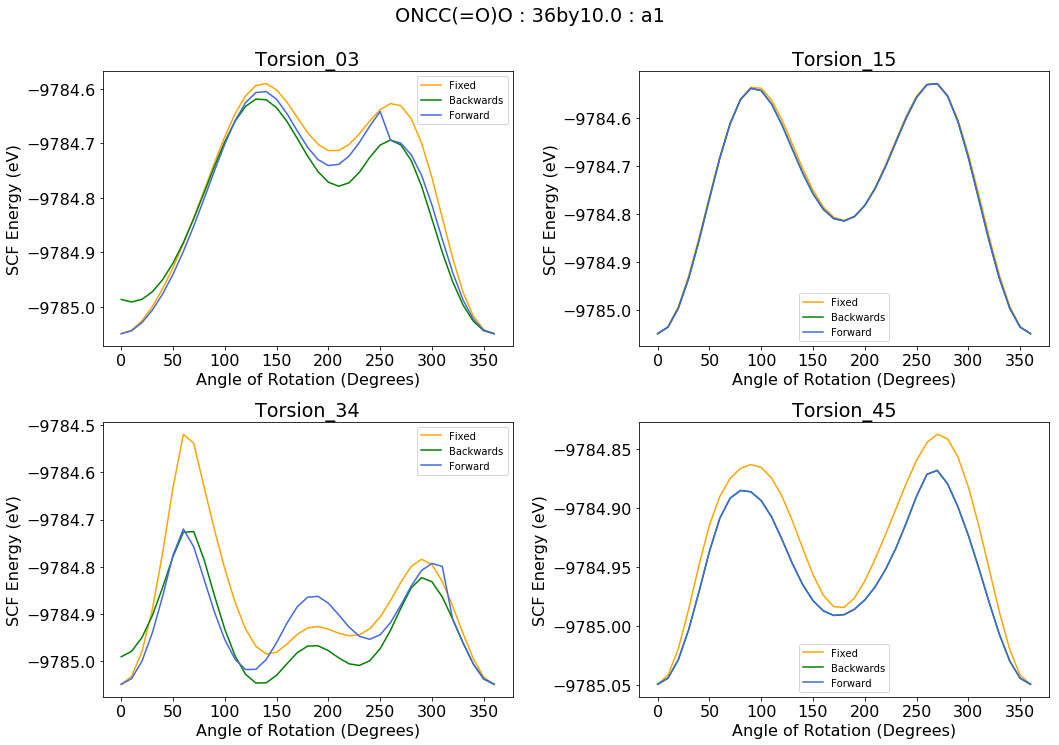

In [11]:
steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [
    'ONCC(=O)O',
    'OOCC(C)O[O]',
    'CCCCO',
    'CCCC[O]',
    'CCC[CH]O',
    'CC[CH]CO',
    'C[CH]CCO',
    '[CH2]CCCO',
    'CCOC',
    'C[CH]OC',
    'CCO[CH2]',
    '[CH2]COC',
    'COC(C)C',
    'CO[C](C)C',
    '[CH2]OC(C)C',
    '[CH2]C(C)OC',
    'CCC(=O)OC',
    'C[CH]C(=O)OC',
    '[CH2]CC(=O)OC',
    '[CH2]OC(=O)CC'
]


print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run2' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

['OOCC(C)O[O]']


<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

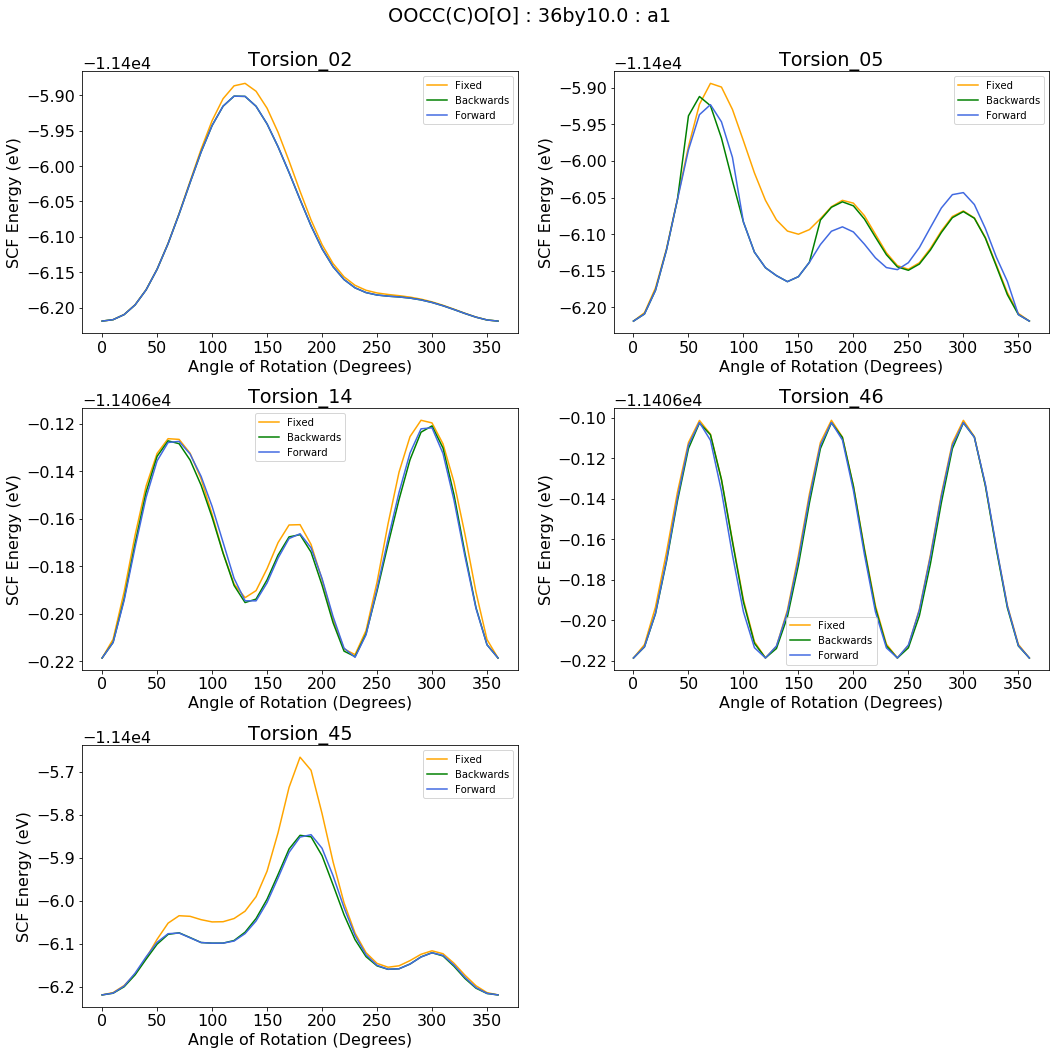

In [10]:

#SMILES = 'HOOCH2CH(CH3)OO'

SMILES = 'OOCC(C)O[O]'
conf = Conformer(SMILES)
#conf.view()
#print conf.smiles
#print conf.ase_molecule.get_chemical_formula()




steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = ['OOCC(C)O[O]']
"""SMILES_list = ['OOCC(C)O[O]',
               'ONCC(=O)O']"""
print SMILES_list
#print conf.rmg_molecule.toAugmentedInChIKey()

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run3' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

In [38]:


steps = 72
step_size = 10.0

Conf_list = []

Rxn_list = None

Master_SMILES_list = [
    'CCCCO',
    'CCCC[O]',
    'CCC[CH]O',
    'CC[CH]CO',
    'C[CH]CCO',
    '[CH2]CCCO',
    'CCOC',
    'C[CH]OC',
    'CCO[CH2]',
    '[CH2]COC',
    'COC(C)C',
    'CO[C](C)C',
    '[CH2]OC(C)C',
    '[CH2]C(C)OC',
    'CCC(=O)OC',
    'C[CH]C(=O)OC',
    '[CH2]CC(=O)OC',
    '[CH2]OC(=O)CC'
]


In [7]:
"""auto_job = AutoTST_Job()

SMILES_list = ['ONCC(=O)O']
Conf_list = []
Rxn_list = None


assert (SMILES_list is not None) or (Rxn_list is not None) or (len(Conf_list)!=0)

if (Rxn_list is not None):
    for rxn in Rxn_list:
        for species in rxn.reactants:
            for reac_list in species.conformers.values():
                Conf_list += reac_list

        for species in rxn.products:
            for prod_list in species.conformers.values():
                Conf_list += prod_list


Conf_list += [Conformer(SMILES) for SMILES in SMILES_list]


for conf in Conf_list:
    conf = Conformer(SMILES)
    path = '/home/underkoffler.c/Code/Hindered_Rotors/{}/From_Workflow'.format(SMILES)

    os.chdir(path)

    augInChIKey = Chem.rdinchi.InchiToInchiKey(Chem.MolToInchi(
        Chem.MolFromSmiles(SMILES)))
                
    (i, j, k, l) = conf.torsions[0].atom_indices

    steps = 72
    step_size = 10.0
    tor_base = '{0}_{1}by{2}_tor{3}{4}'.format(augInChIKey, steps, step_size, j, k)

    prev_attempt = 10
    file_name = tor_base + '_a{}.log'.format(prev_attempt)

    while not os.path.isfile(file_name):
        prev_attempt -= 1
        assert prev_attempt != 0
        file_name = tor_base + '_a{}.log'.format(prev_attempt)
    print SMILES
    print '  Previous Attempt: ', prev_attempt
    print"""
x=1

In [8]:
"""for source, conf in conf_dict.items():
    with open('del_conf.pickle', 'wb') as f:
        positions = conf.ase_molecule.get_positions()
        atomnos = conf.ase_molecule.get_atomic_numbers()
        chem_symb = conf.ase_molecule.get_chemical_symbols()
        energy = conf.energy
        
        info = [
            positions,
            atomnos,
            chem_symb,
            energy
        ]
        
        pickle.dump(info, f)
    
    break"""
x=1

In [9]:
SMILES = 'ONCC(=O)O'
onc_conf = Conformer(SMILES) 
onc_conf.view()

You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/ONCC(=O)O/From_Workflow


Found:  NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by10.0_tor03_a1_F.log
ONCC(=O)O
<Torsion "(9, 0, 3, 4)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37
Max:  -9784.59019838


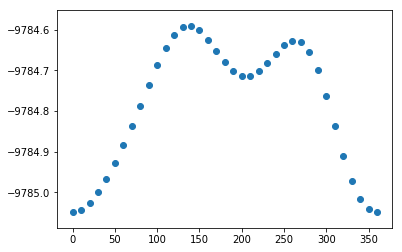

Continuous:   True

Good Slope:   True

Lowest Conf:  True



Found:  NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by10.0_tor03_a1.log
ONCC(=O)O
<Torsion "(9, 0, 3, 4)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37
Max:  -9784.60477473


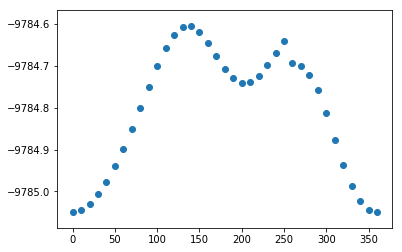

Continuous:   True

Good Slope:   True

Lowest Conf:  True




Found:  NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by10.0_tor15_a1_F.log
ONCC(=O)O
<Torsion "(10, 1, 5, 4)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37
Max:  -9784.52906095


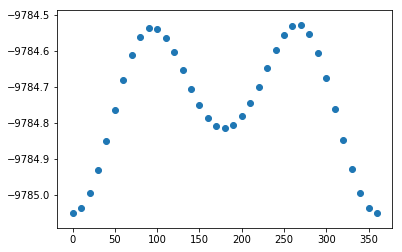

Continuous:   True

Good Slope:   True

Lowest Conf:  True



Found:  NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by10.0_tor15_a1.log
ONCC(=O)O
<Torsion "(10, 1, 5, 4)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37
Max:  -9784.5291009


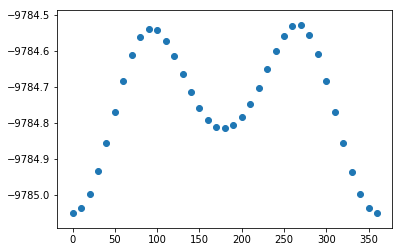

Continuous:   True

Good Slope:   True

Lowest Conf:  True




Found:  NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by10.0_tor34_a1_F.log
ONCC(=O)O
<Torsion "(8, 3, 4, 7)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37
Max:  -9784.51896899


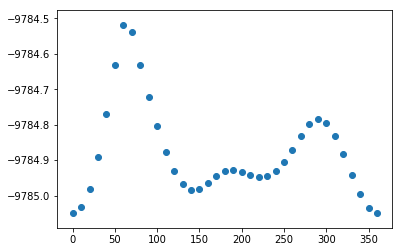

Continuous:   True

Good Slope:   True

Lowest Conf:  True



Found:  NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by10.0_tor34_a1.log
ONCC(=O)O
<Torsion "(8, 3, 4, 7)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37
Max:  -9784.71992362


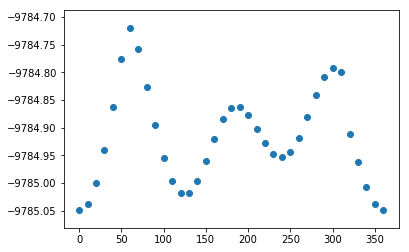

Continuous:   True

Good Slope:   True

Lowest Conf:  True




Found:  NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by10.0_tor45_a1_F.log
ONCC(=O)O
<Torsion "(7, 4, 5, 2)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37
Max:  -9784.8371411


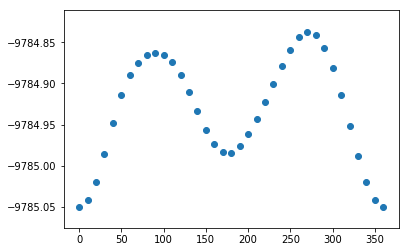

Continuous:   True

Good Slope:   True

Lowest Conf:  True



Found:  NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by10.0_tor45_a1.log
ONCC(=O)O
<Torsion "(7, 4, 5, 2)">
Steps:      36
Step Size:  10.0
Attempt:    1

37 37
Max:  -9784.86782321


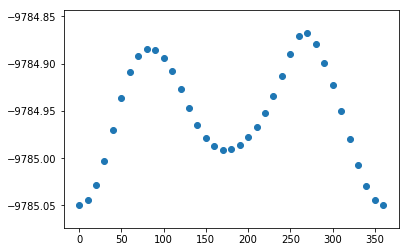

Continuous:   True

Good Slope:   True

Lowest Conf:  True






In [10]:
steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = ['ONCC(=O)O']
base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run2' 



auto_job = AutoTST_Job()
assert (SMILES_list is not None) or (Rxn_list is not None) or (len(Conf_list)!=0)

if (Rxn_list is not None):
    for rxn in Rxn_list:
        for species in rxn.reactants:
            for reac_list in species.conformers.values():
                Conf_list += reac_list

        for species in rxn.products:
            for prod_list in species.conformers.values():
                Conf_list += prod_list


Conf_list += [Conformer(SMILES) for SMILES in SMILES_list]

for conf in Conf_list:
    SMILES = conf.smiles

    augInChIKey = Chem.rdinchi.InchiToInchiKey(Chem.MolToInchi(
        Chem.MolFromSmiles(SMILES)))

    conf.view()
    path = '{}/{}/From_Workflow'.format(base_path, SMILES)
    os.chdir(path)
    print os.getcwd()

    for torsion in conf.torsions:
        print
        attempt = 1
        while attempt < 2:
            c_attempt = attempt
            attempt += 1

            [i, j, k, l] = torsion.atom_indices 

            output_log1 = augInChIKey + '_{0}by{1}_tor{2}{3}_a{4}_F.log'.format(steps, step_size, j, k, c_attempt)
            output_log2 = augInChIKey + '_{0}by{1}_tor{2}{3}_a{4}.log'.format(steps, step_size, j, k, c_attempt)
            
            logs = [output_log1, output_log2]
            for output_log in logs:
                if not exists_and_complete(output_log):
                    print 'DNFind: ', output_log
                    continue
                else:
                    print '\nFound: ', output_log

                print SMILES
                print torsion
                print 'Steps:     ', steps
                print 'Step Size: ', step_size
                print 'Attempt:   ', c_attempt
                print



                opt_SCFenergies, parser = get_opt_energies(output_log)
                thetas = [i*step_size for i in range(steps+1)]
                print len(thetas), len(opt_SCFenergies)
                print "Max: ", max(opt_SCFenergies)

                try:
                    assert len(thetas) == len(opt_SCFenergies)
                    plt.scatter(thetas, opt_SCFenergies)
                    #plt.ylim(-9785.1, -9784.5)
                    #plt.xticks(np.arange(0, -720, step=-90))
                    plt.show()
                except:
                    print 'thetas and energies do not have the same size' 

                print 'Continuous:  ', auto_job.check_rotor_continuous(steps, step_size, parser=parser)
                print '\nGood Slope:  ', auto_job.check_rotor_slope(steps, step_size, parser=parser)
                print '\nLowest Conf: ', auto_job.check_rotor_lowest_conf(parser=parser)[0]
                print '=========================================================\n\n'
                """except:
                    print 'CANNOT Load Scan\n'

                    print '=========================================================\n\n'
                """
    print '===================================================================\n\n'


['ONCC(=O)O']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/ONCC(=O)O/From_Workflow

5
4
3
2
1
NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by-10.0_tor03_a1.log
NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by10.0_tor03_a1.log


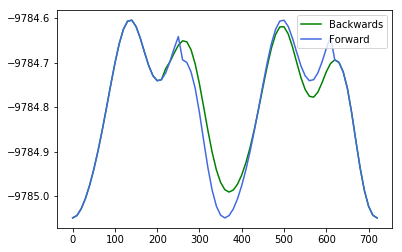

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
1
NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by-10.0_tor15_a1.log
NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by10.0_tor15_a1.log


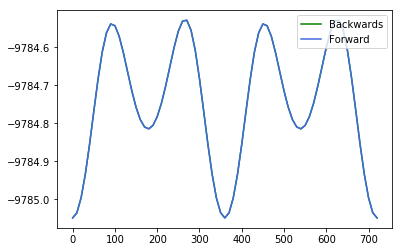

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
1
NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by-10.0_tor34_a1.log
NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by10.0_tor34_a1.log


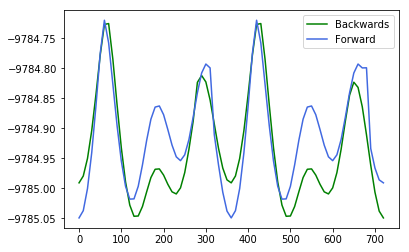

Continuous:   False

Good Slope:   False

Lowest Conf:  True



5
4
3
2
1
NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by-10.0_tor45_a1.log
NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by10.0_tor45_a1.log


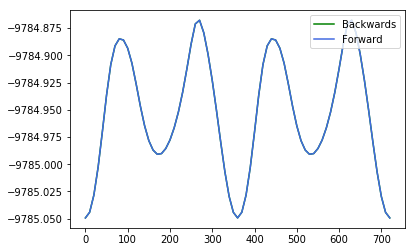

Continuous:   True

Good Slope:   True

Lowest Conf:  True






In [11]:
steps = 72
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = ['ONCC(=O)O']
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run2' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

['ONCC(=O)O']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/ONCC(=O)O/From_Workflow

5
4
3
2
1
NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by5.0_tor03_a1.log


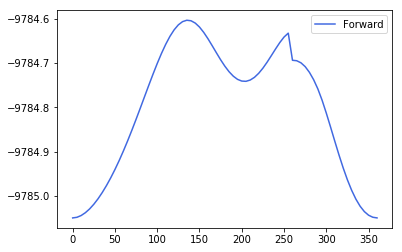

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
1
NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by5.0_tor15_a1.log


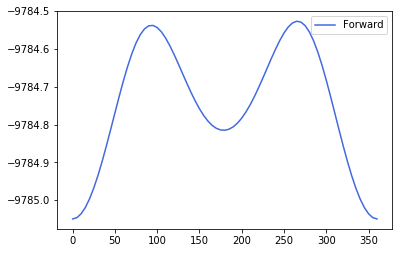

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
1
NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by5.0_tor34_a1.log


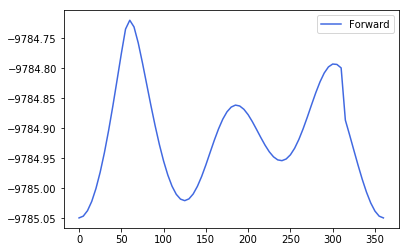

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
1
NPWGWQRXHVJJRD-UHFFFAOYSA-N_72by5.0_tor45_a1.log


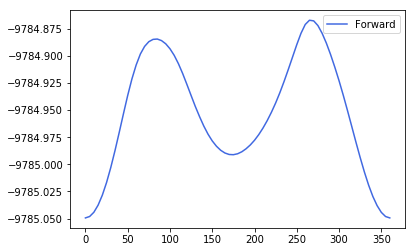

Continuous:   True

Good Slope:   True

Lowest Conf:  True






In [12]:
steps = 72
step_size = 5.0

Conf_list = []

Rxn_list = None

SMILES_list = ['ONCC(=O)O']
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run2' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

['ONCC(=O)O']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/ONCC(=O)O/From_Workflow
5


4


3


2


1
NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by10.0_tor03_a1_F.log
NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by-10.0_tor03_a1.log
NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by10.0_tor03_a1.log
Continuous:   True

Good Slope:   True

Lowest Conf:  True


NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by10.0_tor15_a1_F.log
NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by-10.0_tor15_a1.log
NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by10.0_tor15_a1.log
Continuous:   True

Good Slope:   True

Lowest Conf:  True


NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by10.0_tor34_a1_F.log
NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by-10.0_tor34_a1.log
NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by10.0_tor34_a1.log
Continuous:   True

Good Slope:   True

Lowest Conf:  True


NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by10.0_tor45_a1_F.log
NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by-10.0_tor45_a1.log
NPWGWQRXHVJJRD-UHFFFAOYSA-N_36by10.0_tor45_a1.log
Continuous:   True

Good Slope:   True

Lowest Conf:  True






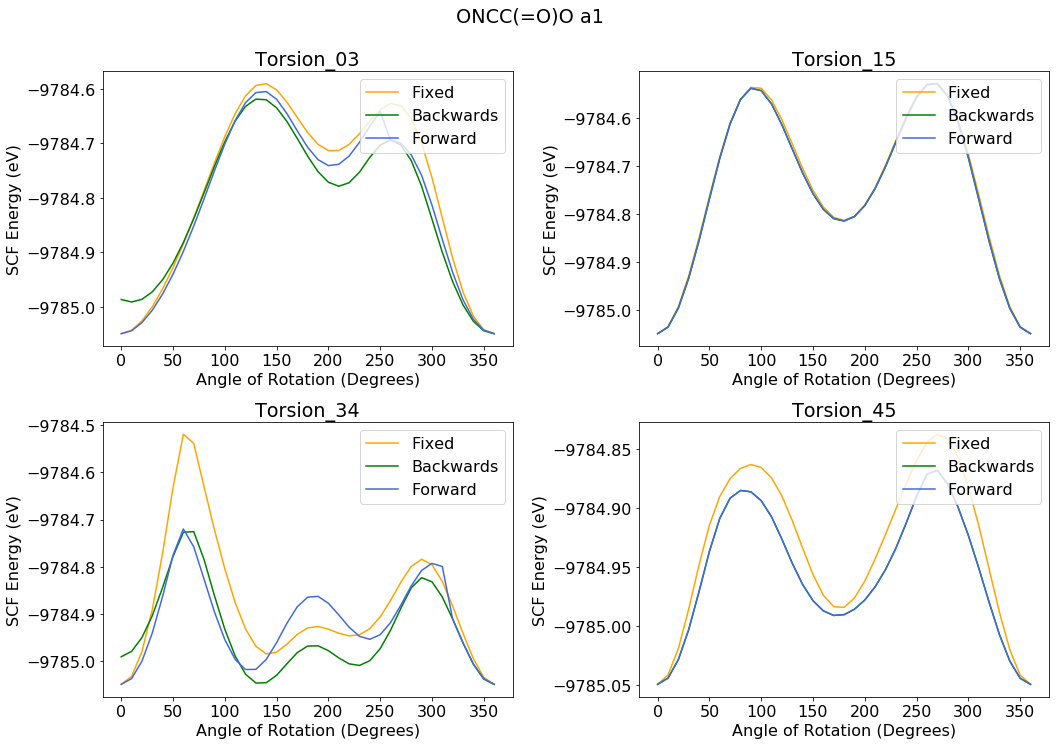

In [41]:
steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = ['ONCC(=O)O']
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run2' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

['CCCCO']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/CCCCO/From_Workflow

5
4
3
2
LRHPLDYGYMQRHN-UHFFFAOYSA-N_36by10.0_tor03_a2.log


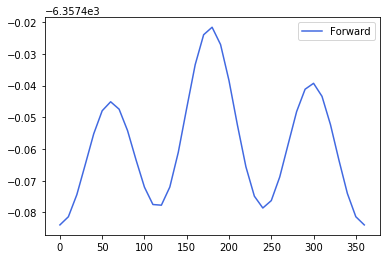

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
LRHPLDYGYMQRHN-UHFFFAOYSA-N_36by10.0_tor13_a2.log


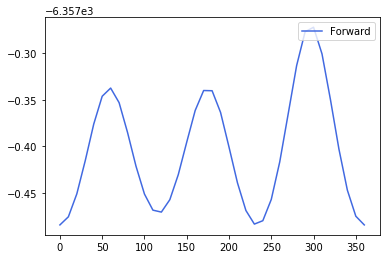

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
LRHPLDYGYMQRHN-UHFFFAOYSA-N_36by10.0_tor12_a2.log


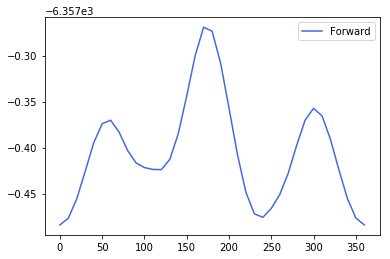

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
LRHPLDYGYMQRHN-UHFFFAOYSA-N_36by10.0_tor24_a2.log


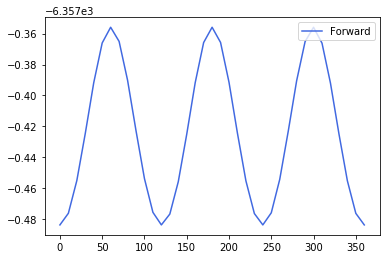

Continuous:   True

Good Slope:   True

Lowest Conf:  True






In [15]:
steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[0]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run2' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

In [ ]:
steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[1]]
print SMILES_list
SMILES = SMILES_list[0]

conf = Conformer(SMILES)

augInChIKey = Chem.rdinchi.InchiToInchiKey(Chem.MolToInchi(
            Chem.MolFromSmiles(SMILES)))
    

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run2' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

In [17]:
"""for key in geos:
    atomcoords, energy = geos[key]

    new_conf = Conformer(SMILES)    
    new_conf.ase_molecule.set_positions(atomcoords)
    new_conf.update_coords_from(mol_type='ase')

    new_conf.ase_molecule.set_calculator(Hotbit())
    new_conf.energy = new_conf.ase_molecule.get_potential_energy()

    conf_dict[key] = new_conf
"""
#sconf_dict['hotbit_gen'] = hotbit_lowest_conf(SMILES)
"""    
pickle_dict = {}
for key, conf in sconf_dict.items():
    SMILES = conf.smiles
    atomcoords = conf.ase_molecule.get_positions()
    energy = conf.energy
    pickle_dict[key] = [SMILES, atomcoords, energy]
"""    

x=1

['CCC[CH]O']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/CCC[CH]O/From_Workflow

5
4
3
DHVSQGCGLGSLDF-UHFFFAOYSA-N_36by10.0_tor04_a3_F.log
DHVSQGCGLGSLDF-UHFFFAOYSA-N_36by-10.0_tor04_a3.log
DHVSQGCGLGSLDF-UHFFFAOYSA-N_36by10.0_tor04_a3.log


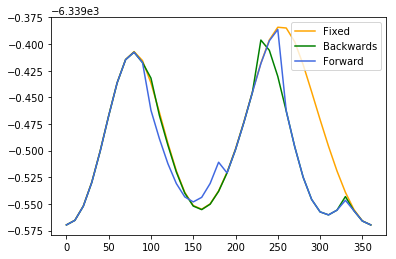

Continuous:   True

Good Slope:   False

Lowest Conf:  True



5
4
3
DHVSQGCGLGSLDF-UHFFFAOYSA-N_36by10.0_tor13_a3_F.log
DHVSQGCGLGSLDF-UHFFFAOYSA-N_36by-10.0_tor13_a3.log
DHVSQGCGLGSLDF-UHFFFAOYSA-N_36by10.0_tor13_a3.log


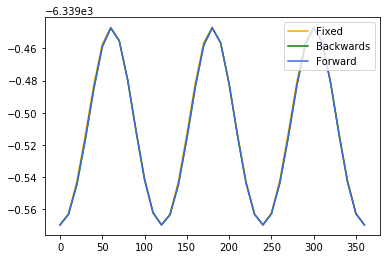

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
DHVSQGCGLGSLDF-UHFFFAOYSA-N_36by10.0_tor12_a3_F.log
DHVSQGCGLGSLDF-UHFFFAOYSA-N_36by-10.0_tor12_a3.log
DHVSQGCGLGSLDF-UHFFFAOYSA-N_36by10.0_tor12_a3.log


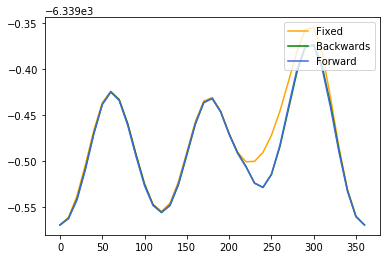

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
DHVSQGCGLGSLDF-UHFFFAOYSA-N_36by10.0_tor24_a3_F.log
DHVSQGCGLGSLDF-UHFFFAOYSA-N_36by-10.0_tor24_a3.log
DHVSQGCGLGSLDF-UHFFFAOYSA-N_36by10.0_tor24_a3.log


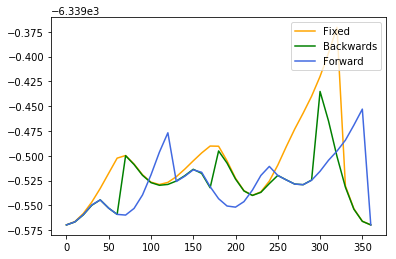

Continuous:   True

Good Slope:   False

Lowest Conf:  True






In [18]:
steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[2]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run2' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

['CC[CH]CO']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/CC[CH]CO/From_Workflow

5
4
3
2
GIXGVIVAHMJKNP-UHFFFAOYSA-N_36by10.0_tor02_a2_F.log
GIXGVIVAHMJKNP-UHFFFAOYSA-N_36by-10.0_tor02_a2.log
GIXGVIVAHMJKNP-UHFFFAOYSA-N_36by10.0_tor02_a2.log


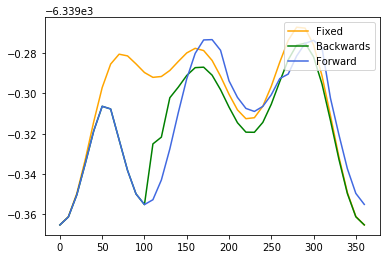

Continuous:   False

Good Slope:   True

Lowest Conf:  True



5
4
3
2
GIXGVIVAHMJKNP-UHFFFAOYSA-N_36by10.0_tor13_a2_F.log
GIXGVIVAHMJKNP-UHFFFAOYSA-N_36by-10.0_tor13_a2.log
GIXGVIVAHMJKNP-UHFFFAOYSA-N_36by10.0_tor13_a2.log


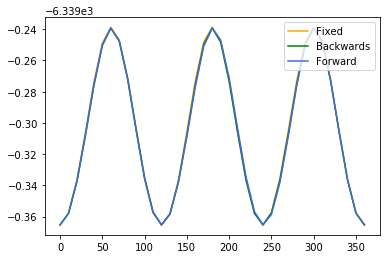

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
GIXGVIVAHMJKNP-UHFFFAOYSA-N_36by10.0_tor14_a2_F.log
GIXGVIVAHMJKNP-UHFFFAOYSA-N_36by-10.0_tor14_a2.log
GIXGVIVAHMJKNP-UHFFFAOYSA-N_36by10.0_tor14_a2.log


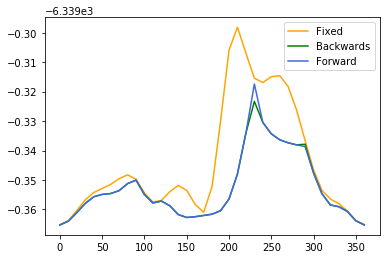

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
GIXGVIVAHMJKNP-UHFFFAOYSA-N_36by10.0_tor24_a2_F.log
GIXGVIVAHMJKNP-UHFFFAOYSA-N_36by-10.0_tor24_a2.log
GIXGVIVAHMJKNP-UHFFFAOYSA-N_36by10.0_tor24_a2.log


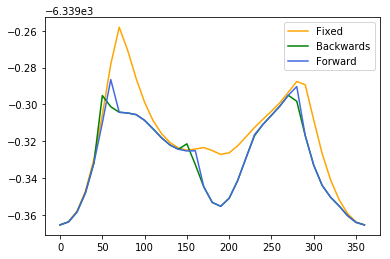

Continuous:   True

Good Slope:   True

Lowest Conf:  True






In [19]:
steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[3]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run2' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

['C[CH]CCO']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/C[CH]CCO/From_Workflow

5
4
3
2
1
DBQZVPSKYUCKNT-UHFFFAOYSA-N_36by10.0_tor02_a1_F.log
DBQZVPSKYUCKNT-UHFFFAOYSA-N_36by-10.0_tor02_a1.log
DBQZVPSKYUCKNT-UHFFFAOYSA-N_36by10.0_tor02_a1.log


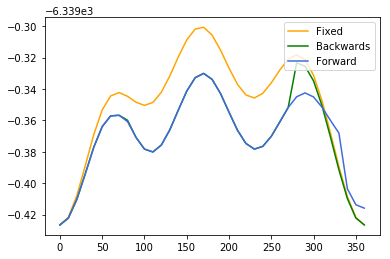

Continuous:   False

Good Slope:   False

Lowest Conf:  True



5
4
3
2
1
DBQZVPSKYUCKNT-UHFFFAOYSA-N_36by10.0_tor12_a1_F.log
DBQZVPSKYUCKNT-UHFFFAOYSA-N_36by-10.0_tor12_a1.log
DBQZVPSKYUCKNT-UHFFFAOYSA-N_36by10.0_tor12_a1.log


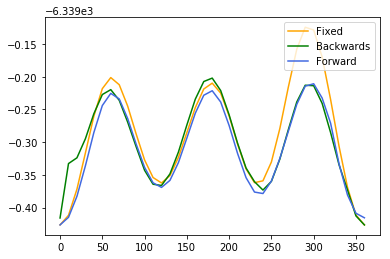

Continuous:   False

Good Slope:   True

Lowest Conf:  True



5
4
3
2
1
DBQZVPSKYUCKNT-UHFFFAOYSA-N_36by10.0_tor14_a1_F.log
DBQZVPSKYUCKNT-UHFFFAOYSA-N_36by-10.0_tor14_a1.log
DBQZVPSKYUCKNT-UHFFFAOYSA-N_36by10.0_tor14_a1.log


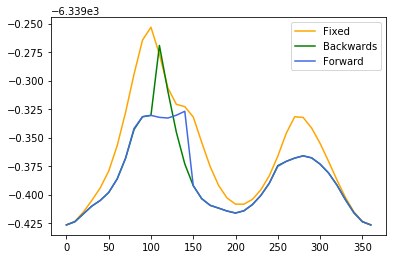

Continuous:   True

Good Slope:   False

Lowest Conf:  True



5
4
3
2
1
DBQZVPSKYUCKNT-UHFFFAOYSA-N_36by10.0_tor34_a1_F.log
DBQZVPSKYUCKNT-UHFFFAOYSA-N_36by-10.0_tor34_a1.log
DBQZVPSKYUCKNT-UHFFFAOYSA-N_36by10.0_tor34_a1.log


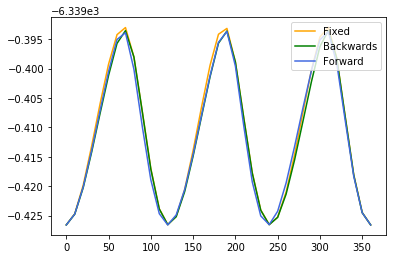

Continuous:   True

Good Slope:   True

Lowest Conf:  True






In [20]:
steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[4]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run2' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

['[CH2]CCCO']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/[CH2]CCCO/From_Workflow

5
4
3
2
1
SXIFAEWFOJETOA-UHFFFAOYSA-N_36by10.0_tor03_a1_F.log
SXIFAEWFOJETOA-UHFFFAOYSA-N_36by-10.0_tor03_a1.log
SXIFAEWFOJETOA-UHFFFAOYSA-N_36by10.0_tor03_a1.log


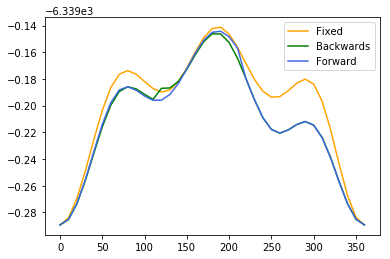

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
1
SXIFAEWFOJETOA-UHFFFAOYSA-N_36by10.0_tor13_a1_F.log
SXIFAEWFOJETOA-UHFFFAOYSA-N_36by-10.0_tor13_a1.log
SXIFAEWFOJETOA-UHFFFAOYSA-N_36by10.0_tor13_a1.log


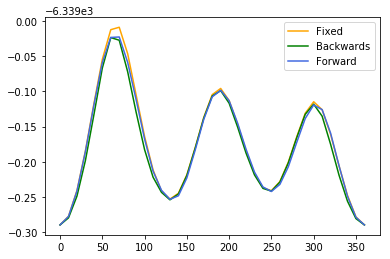

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
1
SXIFAEWFOJETOA-UHFFFAOYSA-N_36by10.0_tor12_a1_F.log
SXIFAEWFOJETOA-UHFFFAOYSA-N_36by-10.0_tor12_a1.log
SXIFAEWFOJETOA-UHFFFAOYSA-N_36by10.0_tor12_a1.log


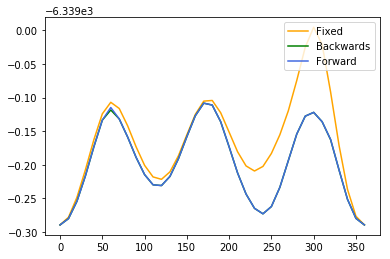

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
1
SXIFAEWFOJETOA-UHFFFAOYSA-N_36by10.0_tor24_a1_F.log
SXIFAEWFOJETOA-UHFFFAOYSA-N_36by-10.0_tor24_a1.log
SXIFAEWFOJETOA-UHFFFAOYSA-N_36by10.0_tor24_a1.log


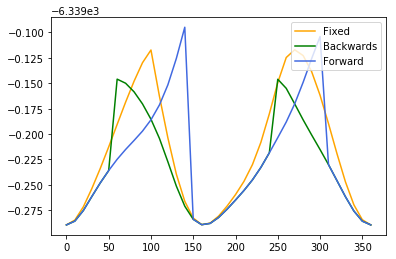

Continuous:   True

Good Slope:   False

Lowest Conf:  True






In [21]:
steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[5]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run2' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

['CCOC']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/CCOC/From_Workflow

5
4
3
2
1
XOBKSJJDNFUZPF-UHFFFAOYSA-N_36by-10.0_tor03_a1.log
XOBKSJJDNFUZPF-UHFFFAOYSA-N_36by10.0_tor03_a1.log


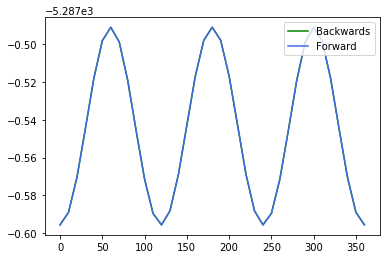

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
1
XOBKSJJDNFUZPF-UHFFFAOYSA-N_36by-10.0_tor01_a1.log
XOBKSJJDNFUZPF-UHFFFAOYSA-N_36by10.0_tor01_a1.log


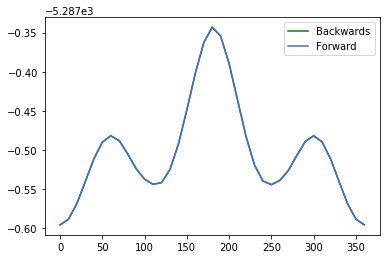

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
1
XOBKSJJDNFUZPF-UHFFFAOYSA-N_36by-10.0_tor12_a1.log
XOBKSJJDNFUZPF-UHFFFAOYSA-N_36by10.0_tor12_a1.log


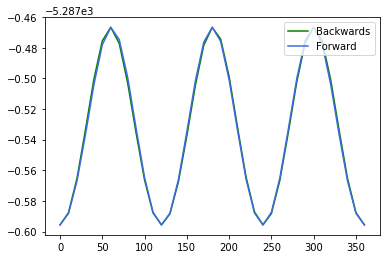

Continuous:   True

Good Slope:   True

Lowest Conf:  True






In [22]:
steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[6]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run2' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

['C[CH]OC']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/C[CH]OC/From_Workflow

5
4
3
2
JQCSUVJDBHJKNG-UHFFFAOYSA-N_36by10.0_tor03_a2_F.log
JQCSUVJDBHJKNG-UHFFFAOYSA-N_36by-10.0_tor03_a2.log
JQCSUVJDBHJKNG-UHFFFAOYSA-N_36by10.0_tor03_a2.log


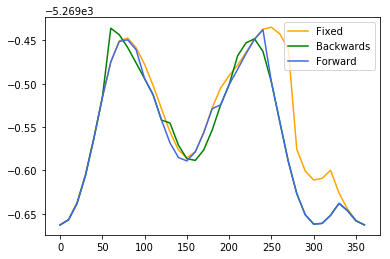

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
JQCSUVJDBHJKNG-UHFFFAOYSA-N_36by10.0_tor02_a2_F.log
JQCSUVJDBHJKNG-UHFFFAOYSA-N_36by-10.0_tor02_a2.log
JQCSUVJDBHJKNG-UHFFFAOYSA-N_36by10.0_tor02_a2.log


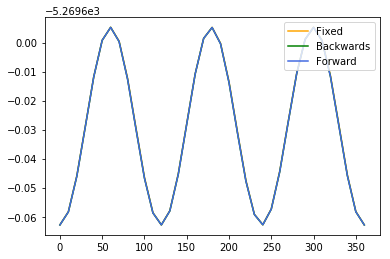

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
JQCSUVJDBHJKNG-UHFFFAOYSA-N_36by10.0_tor13_a2_F.log
JQCSUVJDBHJKNG-UHFFFAOYSA-N_36by-10.0_tor13_a2.log
JQCSUVJDBHJKNG-UHFFFAOYSA-N_36by10.0_tor13_a2.log


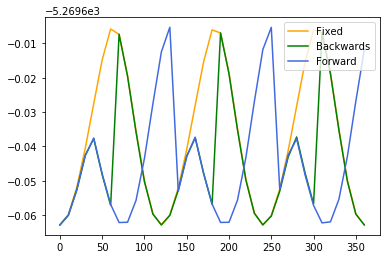

Continuous:   False

Good Slope:   False

Lowest Conf:  True






In [23]:
steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[7]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run2' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

['CCO[CH2]']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/CCO[CH2]/From_Workflow

5
4
3
2
TVFRQKHUZDMLDB-UHFFFAOYSA-N_36by10.0_tor01_a2.log


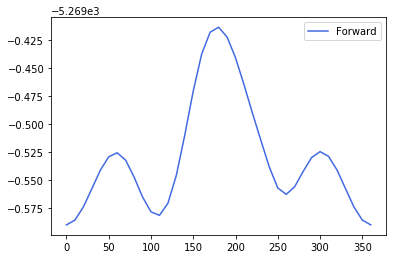

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
TVFRQKHUZDMLDB-UHFFFAOYSA-N_36by10.0_tor03_a2.log


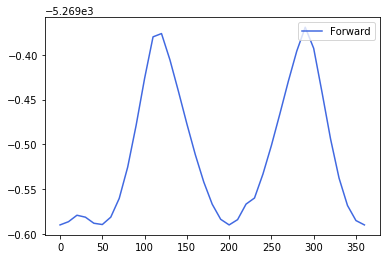

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
TVFRQKHUZDMLDB-UHFFFAOYSA-N_36by10.0_tor12_a2.log


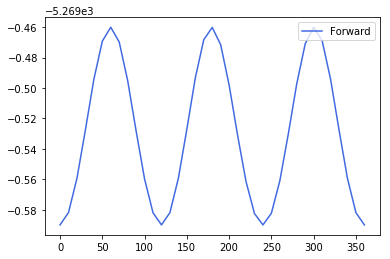

Continuous:   True

Good Slope:   True

Lowest Conf:  True






In [24]:
steps = 72
step_size = 5.0

steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[8]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run2' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

['[CH2]COC']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/[CH2]COC/From_Workflow

5
4
3
2
ZMAYDFGNKOVZRH-UHFFFAOYSA-N_36by10.0_tor01_a2.log


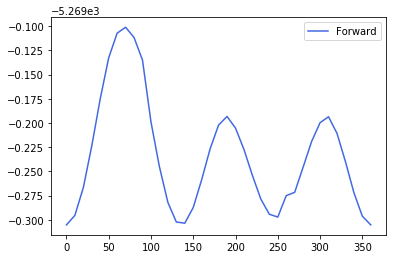

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
ZMAYDFGNKOVZRH-UHFFFAOYSA-N_36by10.0_tor02_a2.log


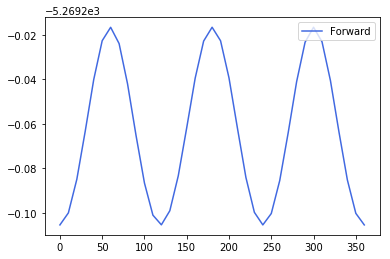

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
ZMAYDFGNKOVZRH-UHFFFAOYSA-N_36by10.0_tor13_a2.log


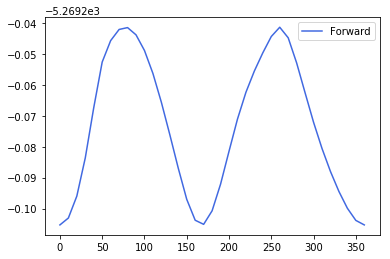

Continuous:   True

Good Slope:   True

Lowest Conf:  True






In [25]:
steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[9]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run2' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

['COC(C)C']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/COC(C)C/From_Workflow

5
4
3
2
1
RMGHERXMTMUMMV-UHFFFAOYSA-N_36by-10.0_tor01_a1.log
RMGHERXMTMUMMV-UHFFFAOYSA-N_36by10.0_tor01_a1.log


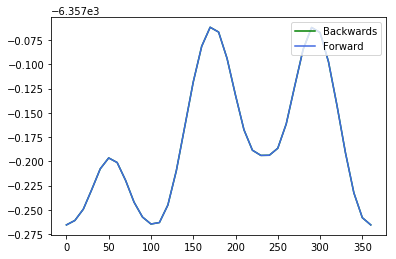

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
1
RMGHERXMTMUMMV-UHFFFAOYSA-N_36by-10.0_tor04_a1.log
RMGHERXMTMUMMV-UHFFFAOYSA-N_36by10.0_tor04_a1.log


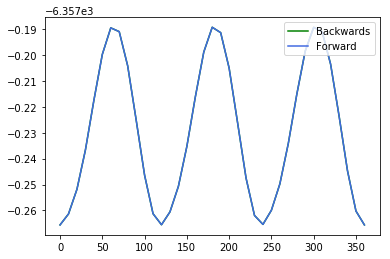

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
1
RMGHERXMTMUMMV-UHFFFAOYSA-N_36by-10.0_tor12_a1.log
RMGHERXMTMUMMV-UHFFFAOYSA-N_36by10.0_tor12_a1.log


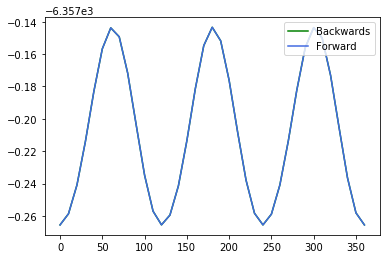

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
1
RMGHERXMTMUMMV-UHFFFAOYSA-N_36by-10.0_tor13_a1.log
RMGHERXMTMUMMV-UHFFFAOYSA-N_36by10.0_tor13_a1.log


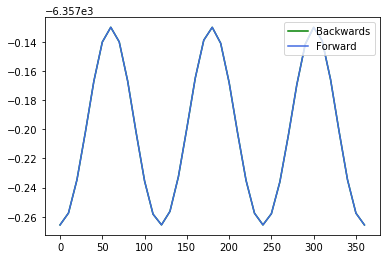

Continuous:   True

Good Slope:   True

Lowest Conf:  True






In [26]:
steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[10]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run2' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

['CO[C](C)C']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/CO[C](C)C/From_Workflow

5
4
3
2
1
VSQGJBCHGBRHMO-UHFFFAOYSA-N_36by-10.0_tor03_a1.log
VSQGJBCHGBRHMO-UHFFFAOYSA-N_36by10.0_tor03_a1.log


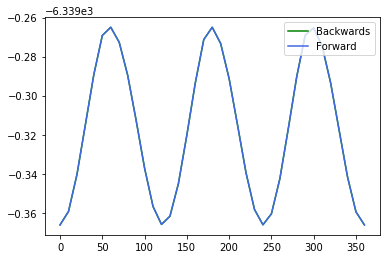

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
1
VSQGJBCHGBRHMO-UHFFFAOYSA-N_36by-10.0_tor04_a1.log
VSQGJBCHGBRHMO-UHFFFAOYSA-N_36by10.0_tor04_a1.log


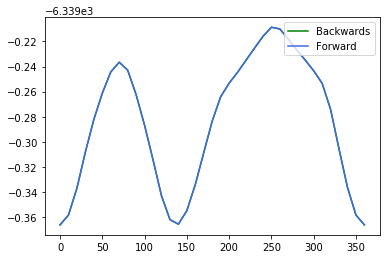

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
1
VSQGJBCHGBRHMO-UHFFFAOYSA-N_36by-10.0_tor14_a1.log
VSQGJBCHGBRHMO-UHFFFAOYSA-N_36by10.0_tor14_a1.log


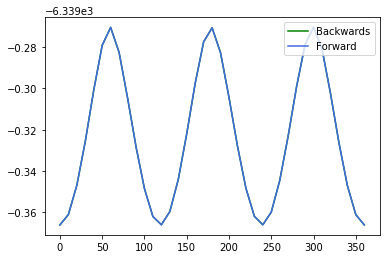

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
1
VSQGJBCHGBRHMO-UHFFFAOYSA-N_36by-10.0_tor24_a1.log
VSQGJBCHGBRHMO-UHFFFAOYSA-N_36by10.0_tor24_a1.log


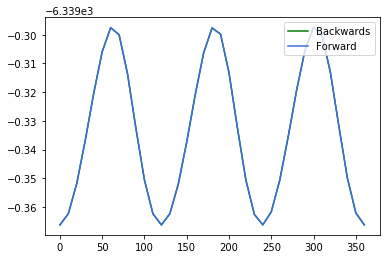

Continuous:   True

Good Slope:   True

Lowest Conf:  True






In [27]:
steps = 36

step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[11]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run2' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

['[CH2]OC(C)C']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/[CH2]OC(C)C/From_Workflow

5
4
3
2
1
BWWHSGPVJDTLAO-UHFFFAOYSA-N_36by-10.0_tor04_a1.log
BWWHSGPVJDTLAO-UHFFFAOYSA-N_36by10.0_tor04_a1.log


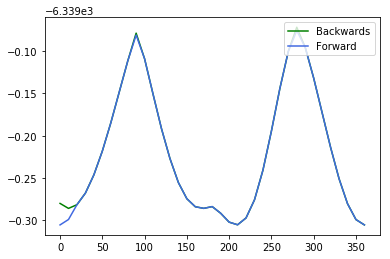

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
1
BWWHSGPVJDTLAO-UHFFFAOYSA-N_36by-10.0_tor01_a1.log
BWWHSGPVJDTLAO-UHFFFAOYSA-N_36by10.0_tor01_a1.log


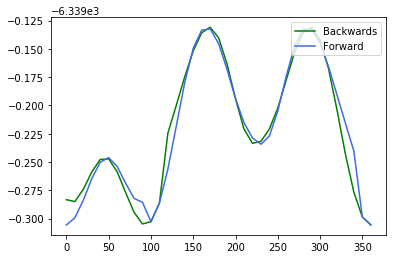

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
1
BWWHSGPVJDTLAO-UHFFFAOYSA-N_36by-10.0_tor13_a1.log
BWWHSGPVJDTLAO-UHFFFAOYSA-N_36by10.0_tor13_a1.log


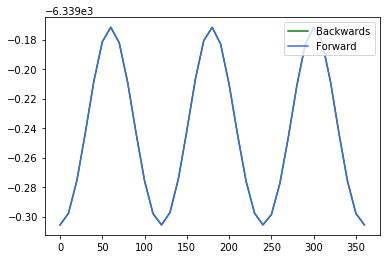

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
1
BWWHSGPVJDTLAO-UHFFFAOYSA-N_36by-10.0_tor12_a1.log
BWWHSGPVJDTLAO-UHFFFAOYSA-N_36by10.0_tor12_a1.log


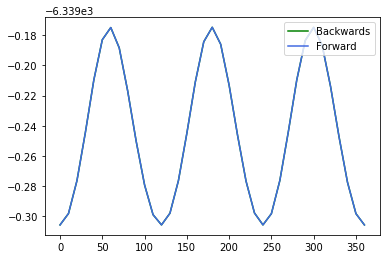

Continuous:   True

Good Slope:   True

Lowest Conf:  True






In [28]:
steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[12]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run2' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

['[CH2]C(C)OC']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/[CH2]C(C)OC/From_Workflow

5
4
3
2
FBRHVBFWGRGMCF-UHFFFAOYSA-N_36by10.0_tor01_a2.log


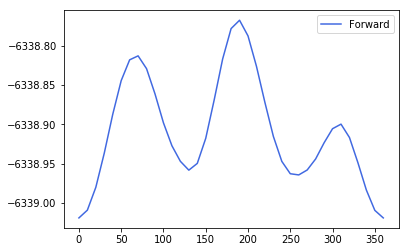

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
FBRHVBFWGRGMCF-UHFFFAOYSA-N_36by10.0_tor03_a2.log


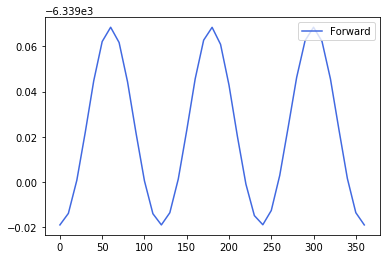

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
FBRHVBFWGRGMCF-UHFFFAOYSA-N_36by10.0_tor12_a2.log


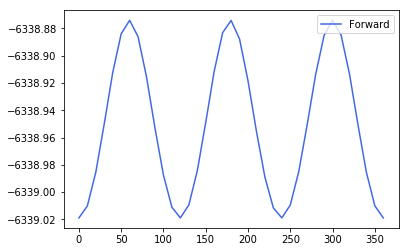

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
FBRHVBFWGRGMCF-UHFFFAOYSA-N_36by10.0_tor14_a2.log


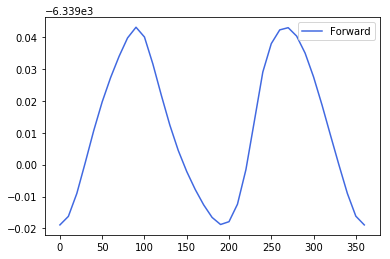

Continuous:   True

Good Slope:   True

Lowest Conf:  True






In [29]:
steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[13]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run2' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

['CCC(=O)OC']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/CCC(=O)OC/From_Workflow

5
4
3
2
1
RJUFJBKOKNCXHH-UHFFFAOYSA-N_36by-10.0_tor04_a1.log
RJUFJBKOKNCXHH-UHFFFAOYSA-N_36by10.0_tor04_a1.log


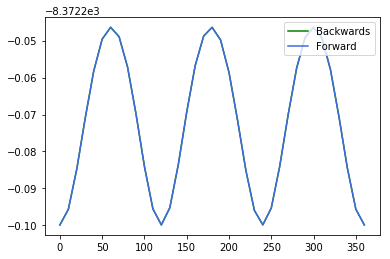

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
1
RJUFJBKOKNCXHH-UHFFFAOYSA-N_36by-10.0_tor05_a1.log
RJUFJBKOKNCXHH-UHFFFAOYSA-N_36by10.0_tor05_a1.log


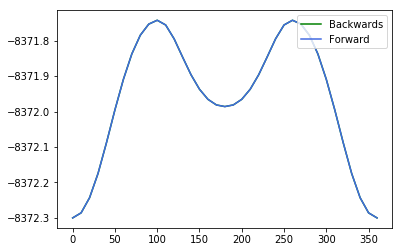

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
1
RJUFJBKOKNCXHH-UHFFFAOYSA-N_36by-10.0_tor23_a1.log
RJUFJBKOKNCXHH-UHFFFAOYSA-N_36by10.0_tor23_a1.log


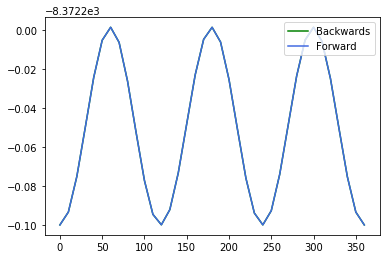

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
1
RJUFJBKOKNCXHH-UHFFFAOYSA-N_36by-10.0_tor25_a1.log
RJUFJBKOKNCXHH-UHFFFAOYSA-N_36by10.0_tor25_a1.log


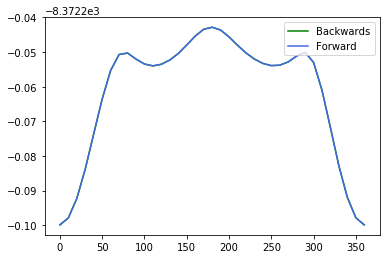

Continuous:   True

Good Slope:   True

Lowest Conf:  True






In [30]:
steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[14]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run2' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

['C[CH]C(=O)OC']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/C[CH]C(=O)OC/From_Workflow

5
4
3
2
1
DUEVIJNWLJUFDM-UHFFFAOYSA-N_36by-10.0_tor03_a1.log
DUEVIJNWLJUFDM-UHFFFAOYSA-N_36by10.0_tor03_a1.log


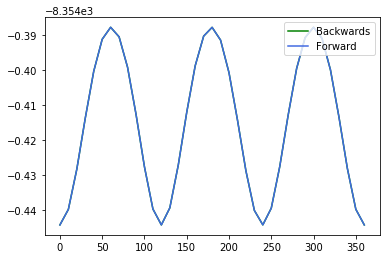

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
1
DUEVIJNWLJUFDM-UHFFFAOYSA-N_36by-10.0_tor05_a1.log
DUEVIJNWLJUFDM-UHFFFAOYSA-N_36by10.0_tor05_a1.log


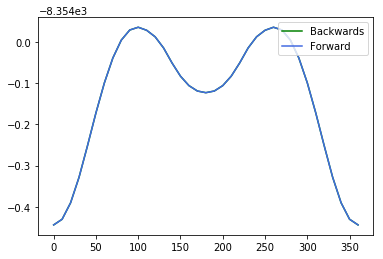

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
1
DUEVIJNWLJUFDM-UHFFFAOYSA-N_36by-10.0_tor24_a1.log
DUEVIJNWLJUFDM-UHFFFAOYSA-N_36by10.0_tor24_a1.log


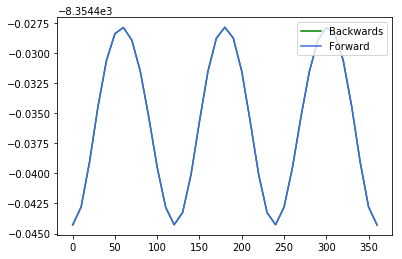

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
1
DUEVIJNWLJUFDM-UHFFFAOYSA-N_36by-10.0_tor45_a1.log
DUEVIJNWLJUFDM-UHFFFAOYSA-N_36by10.0_tor45_a1.log


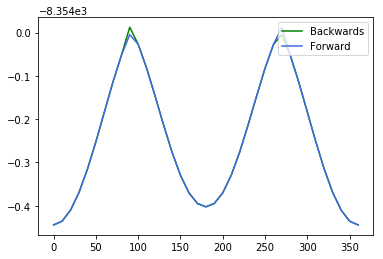

Continuous:   True

Good Slope:   True

Lowest Conf:  True






In [31]:
steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[15]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run2' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

['[CH2]CC(=O)OC']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/[CH2]CC(=O)OC/From_Workflow

5
4
3
2
NPQBOSHSVUVOHJ-UHFFFAOYSA-N_36by10.0_tor04_a2.log


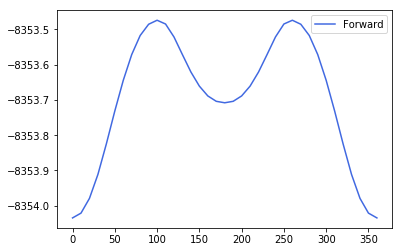

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
NPQBOSHSVUVOHJ-UHFFFAOYSA-N_36by10.0_tor03_a2.log


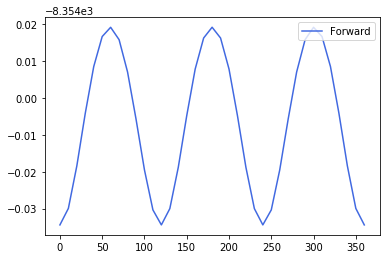

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
NPQBOSHSVUVOHJ-UHFFFAOYSA-N_36by10.0_tor24_a2.log


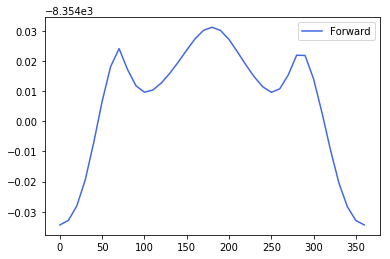

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
NPQBOSHSVUVOHJ-UHFFFAOYSA-N_36by10.0_tor25_a2.log


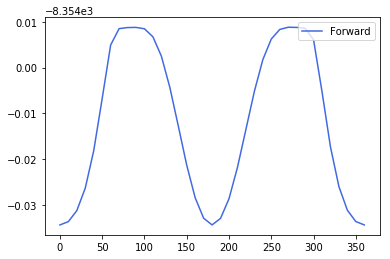

Continuous:   True

Good Slope:   True

Lowest Conf:  True






In [32]:
steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[16]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run2' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

['[CH2]OC(=O)CC']


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

/home/underkoffler.c/Code/Hindered_Rotors/clean_run2/[CH2]OC(=O)CC/From_Workflow

5
4
3
2
1
OJWHOIQFDAGZNF-UHFFFAOYSA-N_36by-10.0_tor04_a1.log
OJWHOIQFDAGZNF-UHFFFAOYSA-N_36by10.0_tor04_a1.log


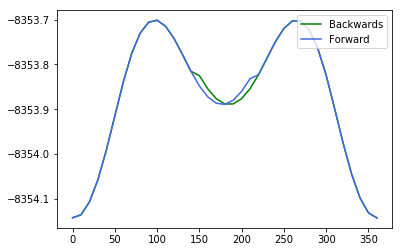

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
1
OJWHOIQFDAGZNF-UHFFFAOYSA-N_36by-10.0_tor05_a1.log
OJWHOIQFDAGZNF-UHFFFAOYSA-N_36by10.0_tor05_a1.log


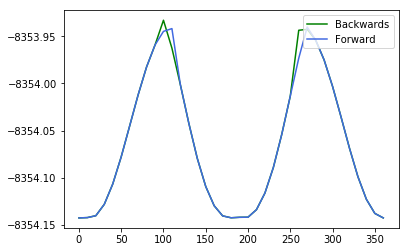

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
1
OJWHOIQFDAGZNF-UHFFFAOYSA-N_36by-10.0_tor24_a1.log
OJWHOIQFDAGZNF-UHFFFAOYSA-N_36by10.0_tor24_a1.log


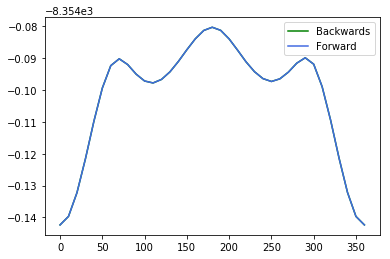

Continuous:   True

Good Slope:   True

Lowest Conf:  True



5
4
3
2
1
OJWHOIQFDAGZNF-UHFFFAOYSA-N_36by-10.0_tor23_a1.log
OJWHOIQFDAGZNF-UHFFFAOYSA-N_36by10.0_tor23_a1.log


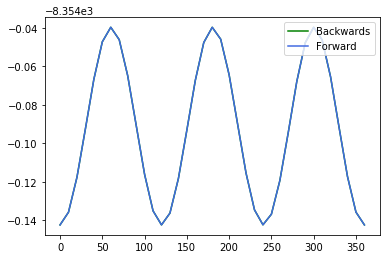

Continuous:   True

Good Slope:   True

Lowest Conf:  True






In [33]:
steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[17]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run2' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

In [34]:
steps = 36
step_size = 10.0

Conf_list = []

Rxn_list = None

SMILES_list = [Master_SMILES_list[18]]
print SMILES_list

base_path = '/home/underkoffler.c/Code/Hindered_Rotors/clean_run2' 
os.chdir(base_path)

scan_progress(steps, step_size, Conf_list, SMILES_list=SMILES_list, Rxn_list=Rxn_list, base_path=base_path)

IndexError: list index out of range

In [ ]:
Molecule?

In [ ]:
from rmgpy.molecule import Molecule

In [ ]:
Molecule?

In [ ]:
test = Molecule(SMILES= 'O=C=O')
test